In [2]:
import subprocess
import sys

# Ensure scipy is up to date
subprocess.check_call([sys.executable, "-m", "pip", "install", "--upgrade", "scipy"])

# Ensure gensim and cython are properly installed
subprocess.check_call([sys.executable, "-m", "pip", "install", "cython"])
subprocess.check_call([sys.executable, "-m", "pip", "install", "--upgrade", "gensim"])

# Import necessary libraries
import os
import random
import pandas as pd
import re
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import functools
from keras import backend as K
import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences  # Updated import
from tensorflow.keras.preprocessing.text import Tokenizer  # Updated import
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, Dropout, Conv1D, MaxPooling1D
from keras.optimizers import Adam
from keras.initializers import Constant

import nltk
from nltk import pos_tag
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords

# Download NLTK datasets
nltk.download("stopwords")  # for removing stop words
nltk.download("wordnet")  # for using wordnet lemmatizer
nltk.download('punkt')  # for using nltk.tokenize.word_tokenize
nltk.download('averaged_perceptron_tagger')  # for using nltk.pos_tag

# Install WordCloud package if not installed
try:
    from wordcloud import WordCloud
except ImportError:
    subprocess.check_call([sys.executable, "-m", "pip", "install", "wordcloud"])
    from wordcloud import WordCloud

# Now gensim can be imported without issues
import gensim

# Load your model if necessary
from keras.models import load_model


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\nagma\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\nagma\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\nagma\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\nagma\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


# Sentiment Analysis Using GloVe Embedding + Averaging and GloVe Embedding + Advanced Architecture

In [4]:
path = "C:\\Users\\nagma\\Downloads\\Reviews.csv"

data = pd.read_csv(path, encoding="utf-8")
data = data.reindex(np.random.permutation(data.index))

print("Shape of data: ", data.shape)
data.head()

Shape of data:  (568454, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
86978,86979,B000LQJT5A,A1CEHGX8NWH6QM,korean friend,0,0,5,1343347200,GOOD PRODUCT,"Nong Shim Neoguri Spicy Seafood Noodle Ramyun,..."
407738,407739,B000EMAZPO,AX1BLGBMHPOSV,KC,5,5,4,1296259200,OK for an easy to find tea.,Let me start by saying I do not find regular L...
445775,445776,B001D0GV7M,A391LVMY75659W,FoxtrotU,0,3,1,1297555200,"Just Weak Coffee, No Mocha To Be Had",I purchased Timothy's Mocha Java because of th...
300225,300226,B001Q9EGFE,A1V81ZAUGS0LE3,Dinubabear,3,5,4,1247702400,Not for picky eaters,The treats come in 3 sizes/shapes. The heart ...
421951,421952,B000CR41KQ,A2KS7YHNBNESZJ,P. M. OMalley,0,0,5,1334102400,pleasing plus healthy,Our dogs adore getting treated but one has rea...


In [6]:
data.loc[[100, 200, 334, 424367, 1446], ["Score", "Summary", "Text"]]

,Score,Summary,Text
100,5,Taste wise it is a 6 star item,"The mouth says, ""How do I love thee, let me co..."
200,2,Altoids Smalls,"Even with small containers, they don't fill th..."
334,1,Does not taste very good,Taste like it is stale. Will not order this a...
424367,4,"Easy to prepare, excellent taste but...a bit t...","I really like Indian food for some reason, esp..."
1446,3,THICK SOUP,"Not bad, but like others say a bit too salty. ..."


In [8]:
reviews_text = data["Text"].values
reviews_title = data["Summary"].values
reviews_rating = data["Score"].values

In [10]:
# nltk libraries

stop_words = set(stopwords.words('english'))

lemmatiser = WordNetLemmatizer()

In [12]:
# returns the Part-Of-Speech(pos) tag which is required as an argument for
# lemmatizer for determiing the context of the word for lemmatization

def get_wordnet_pos(pos_tag):

    if pos_tag.startswith('J'):  
        return 'a' # adjective
    elif pos_tag.startswith('V'): 
        return 'v' # verb
    elif pos_tag.startswith('R'):
        return 'r' # adverb
    else:           
        return 'n' # fallback to noun

In [14]:
# example of lemmatization

example = "move moves moved moving study studies studying studied workers worker working worked go went gone"

tokens = word_tokenize(example) # Generate list of tokens
tokens_pos = pos_tag(tokens) 

print("Original   Lemmatized ")
for tok, tag in tokens_pos:
    pos = get_wordnet_pos(tag)
    print(tok, "       ",lemmatiser.lemmatize(tok, pos=pos))

Original   Lemmatized 
move         move
moves         move
moved         move
moving         move
study         study
studies         study
studying         study
studied         studied
workers         worker
worker         worker
working         work
worked         work
go         go
went         go
gone         go


In [18]:
import re
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk import pos_tag
from nltk.stem import WordNetLemmatizer

# Download necessary NLTK resources
nltk.download("stopwords")
nltk.download("punkt")
nltk.download("averaged_perceptron_tagger")
nltk.download("wordnet")

# Initialize lemmatizer
lemmatiser = WordNetLemmatizer()

# Define stop words
stop_words = set(stopwords.words("english"))

# Function to map POS tag to WordNet POS tag
def get_wordnet_pos(tag):
    if tag.startswith('J'):
        return 'a'  # adjective
    elif tag.startswith('V'):
        return 'v'  # verb
    elif tag.startswith('N'):
        return 'n'  # noun
    elif tag.startswith('R'):
        return 'r'  # adverb
    else:
        return 'n'  # default to noun

# Perform text preprocessing
def preprocess_text(text):
    # lowercase the entire text
    text = text.lower()
    
    # remove all html tags from dataset
    text = re.sub(r'<.*?>', "", text)
    
    # Replace special characters and punctuation by a blank (except for full stop(.))
    text = re.sub(r'[^a-z0-9 \.]', '', text)
    
    # split the text into words
    words = word_tokenize(text) 
    
    # remove stop words like to, an, the, of, over, his, her, there, their ...
    words = [w for w in words if w == "not" or not w in stop_words]
    
    # get POS tagging for words, required by lemmatizer
    words_pos = pos_tag(words) 
    
    lemmatized_words = []
    
    for word, tag in words_pos:
        pos = get_wordnet_pos(tag)
        lemmatized_word = lemmatiser.lemmatize(word, pos=pos)
        lemmatized_words.append(lemmatized_word)
    
    text = " ".join(lemmatized_words)
    
    return text

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\nagma\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\nagma\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\nagma\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\nagma\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [20]:
DATA_SIZE = reviews_text.size

reviews = []
labels = np.zeros(DATA_SIZE)

print(DATA_SIZE)

568454


In [10]:
# data preprocessing step
# will take several minutes!(almost an hour)

for i in range(DATA_SIZE):
    
    text = str(reviews_text[i])
    title = str(reviews_title[i])
    rating = reviews_rating[i]
    
    review = title + " " + text
    review = preprocess_text(review)
    reviews.append(review)

    if(rating > 3.0):
        labels[i] = 1 # Positive Review (1)

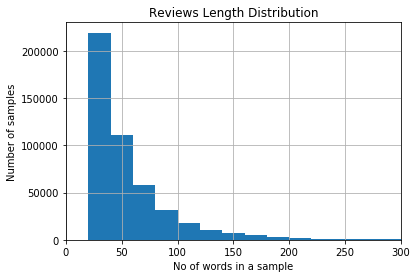

In [11]:
# plot showing lengthwise distribution of reviews

bins = [20*i for i in range(1, 30)]

plt.hist([len(s.split()) for s in reviews], bins=bins)

plt.xlabel('No of words in a review')
plt.ylabel('Number of reviews')
plt.title('Reviews Length Distribution') 

plt.axis([0, 300, 0, 230000])
plt.grid(True)

plt.show()

The majority of reviews are covered if length < 60 words

In [12]:
review_texts = []
review_labels = []

THRESHOLD_WORDS = 60

In [13]:
# considering only those reviews whose length <= (THRESHOLD_WORDS = 60)


for idx, review in enumerate(reviews):
    
    if(len(review.split()) <= THRESHOLD_WORDS):
        review_texts.append(review)
        review_labels.append(labels[idx])
        

In [14]:
review_labels = np.array(review_labels)

In [15]:
NEW_DATA_SIZE = review_labels.shape[0]

In [16]:
# TRAIN - VALIDATION - TEST SPLIT

TRAIN_RATIO = 0.6
VAL_RATIO = 0.2
TRAIN_INDEX = int(TRAIN_RATIO*NEW_DATA_SIZE)
VAL_INDEX = TRAIN_INDEX + int(VAL_RATIO*NEW_DATA_SIZE)

train_texts = review_texts[:TRAIN_INDEX]
y_train = review_labels[:TRAIN_INDEX]

val_texts = review_texts[TRAIN_INDEX:VAL_INDEX]
y_val = review_labels[TRAIN_INDEX:VAL_INDEX]

test_texts = review_texts[VAL_INDEX:]
y_test = review_labels[VAL_INDEX:]


In [17]:
# Random review

RAND_IDX = 78642
print(train_texts[RAND_IDX])
print("Label :", y_train[RAND_IDX])

alltime favorite rice far favorite rice . delicious even without anything hard find store hope amazon keep stock . easy cook perfectly delicious even overcook bit .
Label : 1.0


In [18]:
# calculates median words per sample

def get_num_words_per_sample(sample_texts):
    
    num_words = [len(s.split()) for s in sample_texts]
    return np.median(num_words)

In [19]:
# Facts about the dataset

print("Total training examples :", len(train_texts))
print("Total validation examples :", len(val_texts))
print("Total test dataset ", len(test_texts))
print("\nTotal classes :", 2)

print("\nMedian words per sample in training data : ", get_num_words_per_sample(train_texts))
print("Median words per sample in validation data : ", get_num_words_per_sample(val_texts[2:9]))
print("Median words per sample in test data : ", get_num_words_per_sample(test_texts)) 

Total training examples : 259666
Total validation examples : 86555
Total test dataset  86557

Total classes : 2

Median words per sample in training data :  28.0
Median words per sample in validation data :  28.0
Median words per sample in test data :  28.0


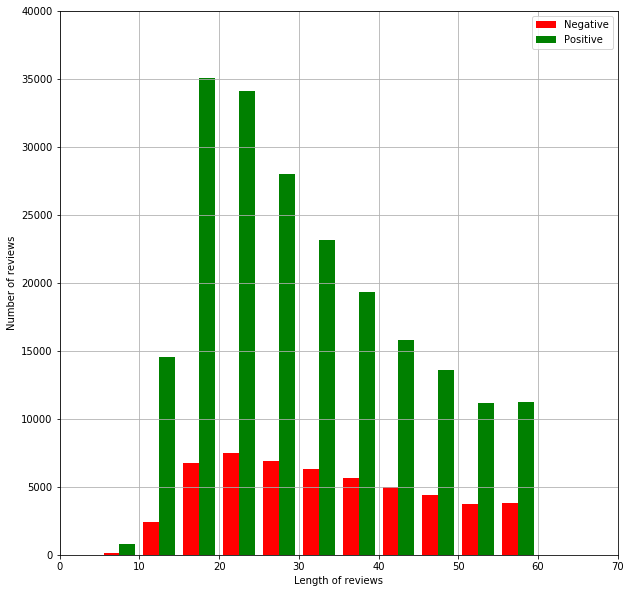

In [20]:
# plot showing lengthwise distribution of reviews labels

y = np.zeros((y_train.shape[0], 2))

for idx, review in enumerate(train_texts):
    l = len(review.split())
  
    if y_train[idx] == 1:
        y[idx][1] = l
    else: 
        y[idx][0] = l
        
mpl.rcParams['figure.figsize'] = (10,10)
        
plotlabels = [ 'Negative', 'Positive']
color = ['red', 'green']    

bins = [5*i for i in range(1,13)]

plt.hist(y,bins = bins,label = plotlabels,color = color)
plt.axis([0, 70, 0, 40000])

plt.title('Reviews Labels Distribution')   
plt.xlabel('Length of reviews')
plt.ylabel('Number of reviews') 

plt.legend()
plt.grid(True)
plt.show()

<BarContainer object of 50 artists>

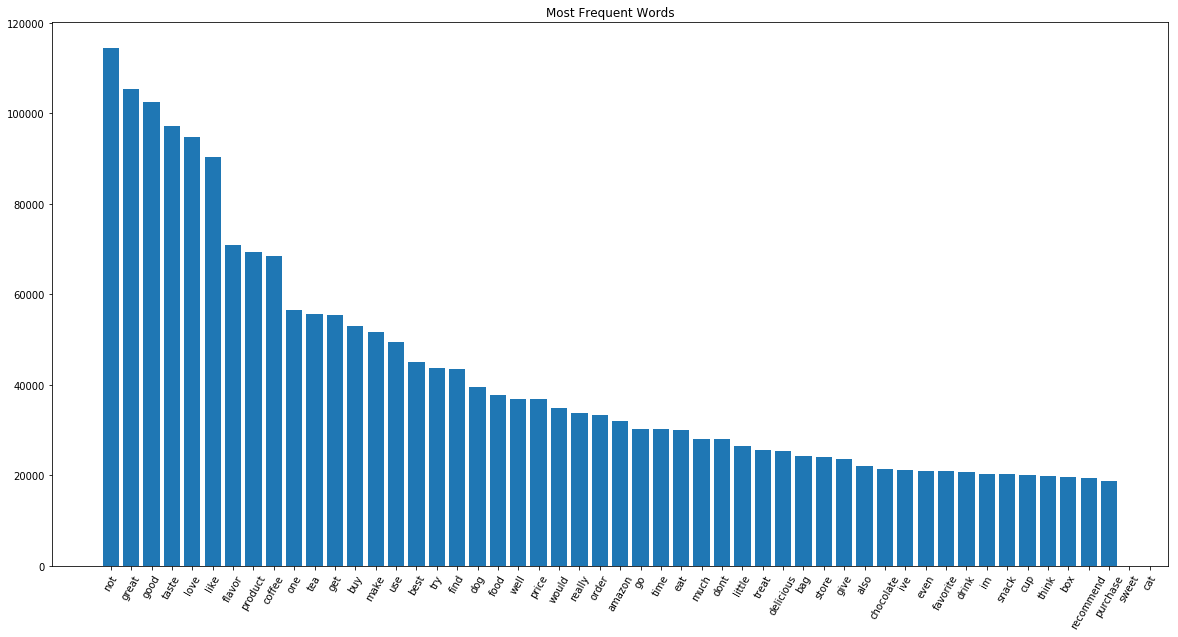

In [21]:
# tokenizing the reviews words

tokenizer = Tokenizer()
tokenizer.fit_on_texts(train_texts)

MOST_K_FREQUENT = 100
TOP_K_FREQUENT = 50

def get_key(word_freq_pair):
    word, freq = word_freq_pair
    return freq
    
# MOST_K_FREQUENT WORDS
frequent_words = sorted(list(tokenizer.word_counts.items()), key = get_key, reverse = True)[:MOST_K_FREQUENT]

x = [i for i in range(MOST_K_FREQUENT)]
x_words = []
y_word_freq = []

for word, count in frequent_words:
    x_words.append(word)
    y_word_freq.append(count)

# plot showing most occuring words in the dataset    

mpl.rcParams['figure.figsize'] = (20,10)

plt.xticks(x, x_words)
plt.xticks(rotation=60)

plt.title("Most Frequent Words")

plt.bar(x[:TOP_K_FREQUENT], y_word_freq[:TOP_K_FREQUENT])

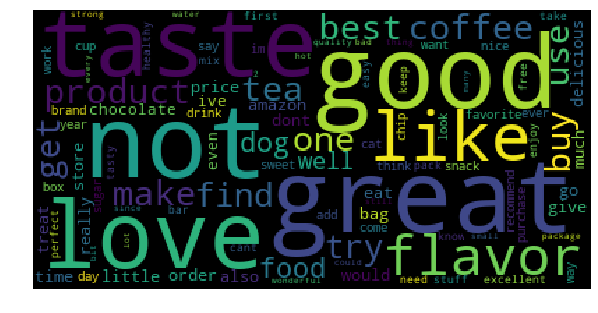

In [22]:
# word cloud showing most occuring words in the dataset

freq_dist = nltk.FreqDist(x_words)

wordcloud = WordCloud().generate_from_frequencies(freq_dist)

mpl.rcParams['figure.figsize'] = (10,10)

plt.imshow(wordcloud)

plt.axis("off")
plt.show()

In [23]:
# Vectorization parameters
# Limit on the number of features. We use the top 20K features.
TOP_K = 20000

# Limit on the length of text sequences. Sequences longer than this
# will be truncated.
MAX_SEQUENCE_LENGTH = THRESHOLD_WORDS

# Create vocabulary with training texts.
# By default, all punctuation is removed
tokenizer = Tokenizer(num_words=TOP_K)
tokenizer.fit_on_texts(train_texts)

# Vectorize training and validation texts.
x_train = tokenizer.texts_to_sequences(train_texts)
x_val = tokenizer.texts_to_sequences(val_texts)
x_test = tokenizer.texts_to_sequences(test_texts)

# Fix sequence length to MAX_SEQUENCE_LENGTH. Sequences shorter than the length are
# padded and sequences longer are truncated
x_train = pad_sequences(x_train, maxlen=MAX_SEQUENCE_LENGTH, padding='post')
x_val = pad_sequences(x_val, maxlen=MAX_SEQUENCE_LENGTH, padding='post')
x_test = pad_sequences(x_test, maxlen=MAX_SEQUENCE_LENGTH, padding='post')
    

In [25]:

# creating dictionary of words containing corresponding word embeddings

filename = "C:\\Users\\nagma\\Downloads\\glove.6B.100d.txt\\glove.6B.100d.txt"

embeddings_index = {}

f = open(filename,  encoding = "utf-8")

for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:])
    embeddings_index[word] = coefs
    
f.close()


In [27]:

# dimension of each word embedding
EMBEDDING_DIM = 100

# creating embedding matrix for directly feeding to Embedding() layer of Keras

num_words = len(tokenizer.word_index)+1
embedding_matrix = np.zeros((num_words, EMBEDDING_DIM))

for word, i in tokenizer.word_index.items():
    
    if i > num_words:
        continue
        
    embedding_vector = embeddings_index.get(word)
    
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector
        

In [40]:
# averages out embedding for each correspondong word in a review

def average_embedding(x_data):
    
    average_embedding_matrix = np.zeros((x_data.shape[0], EMBEDDING_DIM))
    
    for idx, embedding_vector in enumerate(x_data):
        
        average_embedding_vector = np.zeros((EMBEDDING_DIM, ))
        
        for token_index in embedding_vector:
            average_embedding_vector += embedding_matrix[token_index]
        
        average_embedding_vector /= len(embedding_vector)
        average_embedding_matrix[idx] = average_embedding_vector
        
    return average_embedding_matrix

In [41]:
x_avg_train = average_embedding(x_train)
x_avg_val = average_embedding(x_val)
x_avg_test = average_embedding(x_test)

## Averaging Model

In [83]:
model_avg_embedding = Sequential()

model_avg_embedding.add(Dense(250, input_shape=(EMBEDDING_DIM, ), activation='relu'))
model_avg_embedding.add(Dropout(0.3))

model_avg_embedding.add(Dense(100, activation='relu'))
model_avg_embedding.add(Dropout(0.4))

model_avg_embedding.add(Dense(1, activation='sigmoid'))

optimizer = Adam(lr=1e-3, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0, amsgrad=False)

model_avg_embedding.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
model_avg_embedding.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_21 (Dense)             (None, 250)               25250     
_________________________________________________________________
dropout_3 (Dropout)          (None, 250)               0         
_________________________________________________________________
dense_22 (Dense)             (None, 100)               25100     
_________________________________________________________________
dropout_4 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_23 (Dense)             (None, 1)                 101       
Total params: 50,451
Trainable params: 50,451
Non-trainable params: 0
_________________________________________________________________


In [84]:

#training the model
model_avg_embedding_history = model_avg_embedding.fit(x_avg_train, y_train, batch_size=32, epochs=100, validation_data=(x_avg_val, y_val))


Train on 259666 samples, validate on 86555 samples
Epoch 1/100
259666/259666 [==============================] - 38s 147us/step - loss: 0.3312 - acc: 0.8574 - val_loss: 0.3088 - val_acc: 0.8668
Epoch 2/100
259666/259666 [==============================] - 36s 139us/step - loss: 0.3130 - acc: 0.8661 - val_loss: 0.3004 - val_acc: 0.8704
Epoch 3/100
259666/259666 [==============================] - 37s 141us/step - loss: 0.3065 - acc: 0.8689 - val_loss: 0.2989 - val_acc: 0.8727
Epoch 4/100
259666/259666 [==============================] - 37s 142us/step - loss: 0.3023 - acc: 0.8710 - val_loss: 0.2934 - val_acc: 0.8746
Epoch 5/100
259666/259666 [==============================] - 50s 193us/step - loss: 0.2987 - acc: 0.8736 - val_loss: 0.2910 - val_acc: 0.8763
Epoch 6/100
259666/259666 [==============================] - 37s 142us/step - loss: 0.2954 - acc: 0.8741 - val_loss: 0.2972 - val_acc: 0.8745
Epoch 7/100
259666/259666 [==============================] - 35s 137us/step - loss: 0.2929 - acc:

Epoch 58/100
259666/259666 [==============================] - 40s 152us/step - loss: 0.2484 - acc: 0.8968 - val_loss: 0.2668 - val_acc: 0.8936
Epoch 59/100
259666/259666 [==============================] - 42s 161us/step - loss: 0.2481 - acc: 0.8973 - val_loss: 0.2637 - val_acc: 0.8932
Epoch 60/100
259666/259666 [==============================] - 36s 138us/step - loss: 0.2473 - acc: 0.8967 - val_loss: 0.2671 - val_acc: 0.8916
Epoch 61/100
259666/259666 [==============================] - 33s 129us/step - loss: 0.2472 - acc: 0.8976 - val_loss: 0.2629 - val_acc: 0.8948
Epoch 62/100
259666/259666 [==============================] - 35s 134us/step - loss: 0.2471 - acc: 0.8974 - val_loss: 0.2643 - val_acc: 0.8908
Epoch 63/100
259666/259666 [==============================] - 32s 124us/step - loss: 0.2458 - acc: 0.8978 - val_loss: 0.2628 - val_acc: 0.8934
Epoch 64/100
259666/259666 [==============================] - 36s 137us/step - loss: 0.2463 - acc: 0.8975 - val_loss: 0.2675 - val_acc: 0.8927

## Training accuracy - 90.27%
## Validation Accuracy - 89.42%

In [85]:
# model history parameters
history = model_avg_embedding_history.history

train_accuracy = history['acc']
train_loss = history['loss']

val_accuracy = history['val_acc']
val_loss = history['val_loss']

epochs = range(1, len(train_accuracy) + 1)

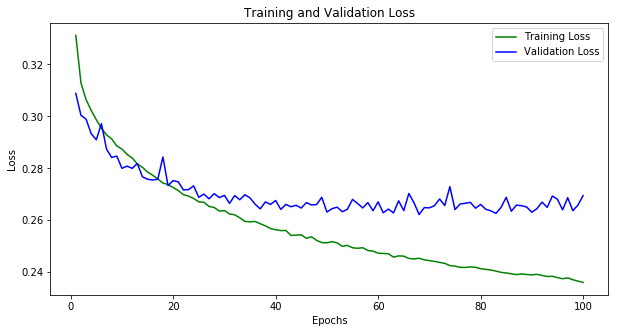

In [86]:
# plot showing training and validation losses

mpl.rcParams['figure.figsize'] = (10, 5)

plt.plot(epochs, train_loss, 'g', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')

plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')

plt.legend()
plt.show()

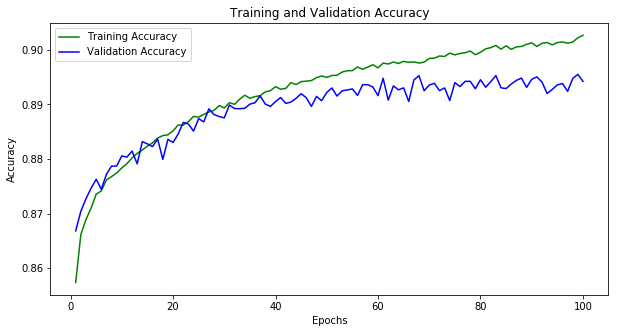

In [87]:
# plot showing training and validation accuracy

plt.plot(epochs, train_accuracy, 'g', label='Training Accuracy')
plt.plot(epochs, val_accuracy, 'b', label='Validation Accuracy')

plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

plt.legend()
plt.show()

In [88]:
# evaluating the model on test dataset
model_avg_embedding.evaluate(x_avg_test, y_test)

86557/86557 [==============================] - 3s 36us/step


[0.2669485517337078, 0.8937694236243822]

## Test accuracy - 89.38%

In [90]:
# custom test samples

samples = [
           "The taste of the biscuits was quite spectacular. It seemed as if it was taken straight from heaven",
           "Peanuts were too salty according to my taste",
            "If you are looking for a secret ingredient, go for it",
            "I am disappointed with the rice",
            "I am not disappointed with the rice",
            "When i first bought this, i was confused about its quality and taste. But after eating this, my children fell in love with me. Thanks!!",
            "I'm not really a tea drinker but my husband is and he loves this tea. So on his behalf I'm recommending it. Just go on with my hubby's recommendation."
          ]

processed_samples = []
for sample in samples:
    processed_samples.append(preprocess_text(sample))

vectorized_samples = tokenizer.texts_to_sequences(processed_samples)
vectorized_samples = pad_sequences(vectorized_samples, maxlen=MAX_SEQUENCE_LENGTH, padding='post')
vectorized_avg_samples = average_embedding(vectorized_samples)

predictions = model_avg_embedding.predict(vectorized_avg_samples)

THRESHOLD_PREDICTION = 0.6

for idx, pred in enumerate(predictions):
    if(pred > THRESHOLD_PREDICTION):
        print(samples[idx], "{}. Positive with {:.2f}% surity".format(idx+1, pred[0]*100))
    else:
        print(samples[idx], "{}. Negative with {:.2f}% surity".format(idx+1, 100-pred[0]*100))


The taste of the biscuits was quite spectacular. It seemed as if it was taken straight from heaven 1. Positive with 97.94% surity
Peanuts were too salty according to my taste 2. Positive with 80.16% surity
If you are looking for a secret ingredient, go for it 3. Positive with 92.07% surity
I am disappointed with the rice 4. Positive with 98.88% surity
I am not disappointed with the rice 5. Negative with 82.43% surity
When i first bought this, i was confused about its quality and taste. But after eating this, my children fell in love with me. Thanks!! 6. Positive with 96.12% surity
I'm not really a tea drinker but my husband is and he loves this tea. So on his behalf I'm recommending it. Just go on with my hubby's recommendation. 7. Positive with 99.90% surity


The 2nd example is wrongly classified.

The 4th example is also wrongly classified. The 5th example is different from 4th one just because it has an extra "not" in it. 

The averaging model is considering "not" to be a negative word and increasing the polarity of sentence in the favor of negative, although the overall polarity should be positive as the customer is "not disappointed". 

The issue here with this model is not only the wrong classification but also that the addition of negative word such as "not" is making the sentence more negative without even considering its effect to the review. 

This is the problem with averaging the embeddings. In addition to low test accuracy (as compared to other models), it is also not taking into account the position of negative/positive words whose placement at any given location in a sentence can change the entire meaning or polarity of it.

In [94]:
# saving the averaging model

model_avg_embedding.save("avg_embedding_model.h5")


## Now using LSTM Model with pre-trained glove embeddings

In [96]:

model_pretrained_glove = Sequential()

embedding_layer = Embedding(len(tokenizer.word_index)+1,
                            EMBEDDING_DIM,
                            embeddings_initializer=Constant(embedding_matrix),
                            input_length=MAX_SEQUENCE_LENGTH,
                            trainable=False)
model_pretrained_glove.add(embedding_layer)
model_pretrained_glove.add(Dropout(0.3))

model_pretrained_glove.add(Conv1D(64, 5, activation='relu'))
model_pretrained_glove.add(MaxPooling1D(pool_size=4))

model_pretrained_glove.add(LSTM(100))
model_pretrained_glove.add(Dropout(0.4))

model_pretrained_glove.add(Dense(1, activation='sigmoid'))

optimizer = Adam(lr=1e-3, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0, amsgrad=False)

model_pretrained_glove.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
model_pretrained_glove.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 60, 100)           9473400   
_________________________________________________________________
dropout_7 (Dropout)          (None, 60, 100)           0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 56, 64)            32064     
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 14, 64)            0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 100)               66000     
_________________________________________________________________
dropout_8 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_25 (Dense)             (None, 1)                 101       
Total para

In [97]:

# training the model
model_pretrained_glove_history = model_pretrained_glove.fit(x_train, y_train, batch_size=32, epochs=10, validation_data=(x_val, y_val))


Train on 259666 samples, validate on 86555 samples
Epoch 1/10
259666/259666 [==============================] - 354s 1ms/step - loss: 0.2729 - acc: 0.8881 - val_loss: 0.2068 - val_acc: 0.9186
Epoch 2/10
259666/259666 [==============================] - 336s 1ms/step - loss: 0.2259 - acc: 0.9096 - val_loss: 0.1970 - val_acc: 0.9236
Epoch 3/10
259666/259666 [==============================] - 337s 1ms/step - loss: 0.2107 - acc: 0.9160 - val_loss: 0.1880 - val_acc: 0.9273
Epoch 4/10
259666/259666 [==============================] - 335s 1ms/step - loss: 0.2018 - acc: 0.9200 - val_loss: 0.1825 - val_acc: 0.9283
Epoch 5/10
259666/259666 [==============================] - 336s 1ms/step - loss: 0.1955 - acc: 0.9228 - val_loss: 0.1818 - val_acc: 0.9288
Epoch 6/10
259666/259666 [==============================] - 348s 1ms/step - loss: 0.1905 - acc: 0.9249 - val_loss: 0.1780 - val_acc: 0.9317
Epoch 7/10
259666/259666 [==============================] - 330s 1ms/step - loss: 0.1877 - acc: 0.9256 - val_

## Training accuracy - 92.92 %
## Validation Accuracy - 93.38 %

In [98]:
# model history parameters

history = model_pretrained_glove_history.history

train_accuracy = history['acc']
train_loss = history['loss']

val_accuracy = history['val_acc']
val_loss = history['val_loss']

epochs = range(1, len(train_accuracy) + 1)

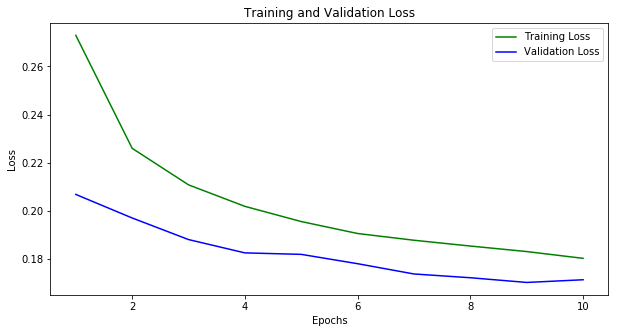

In [99]:
# plot showing training and validation losses

mpl.rcParams['figure.figsize'] = (10, 5)

plt.plot(epochs, train_loss, 'g', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')

plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')

plt.legend()
plt.show()

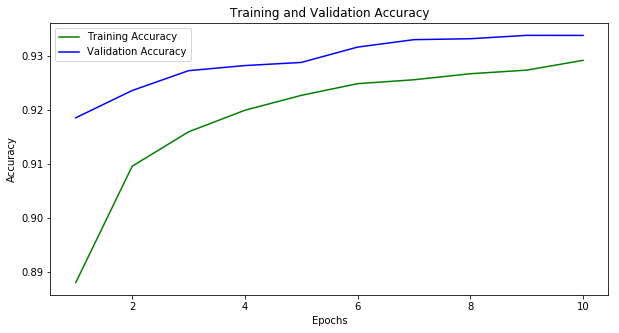

In [100]:
# plot showing training and validation accuracy

plt.plot(epochs, train_accuracy, 'g', label='Training Accuracy')
plt.plot(epochs, val_accuracy, 'b', label='Validation Accuracy')

plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

plt.legend()
plt.show()

In [101]:
# evaluating the model on test dataset
model_pretrained_glove.evaluate(x_test, y_test)

86557/86557 [==============================] - 39s 450us/step


[0.17561808823957303, 0.931328488741523]

## Test accuracy - 93.13 %

In [103]:
# custom test samples

samples = [
           "The taste of the biscuits was quite spectacular. It seemed as if it was taken straight from heaven",
           "Peanuts were too salty according to my taste",
            "If you are looking for a secret ingredient, go for it",
            "I am disappointed with the rice",
            "I am not disappointed with the rice",
            "I'm not really a tea drinker but my husband is and he loves this tea. So on his behalf I'm recommending it. Just go on with my hubby's recommendation."
          ]

processed_samples = []
for sample in samples:
    processed_samples.append(preprocess_text(sample))

vectorized_samples = tokenizer.texts_to_sequences(processed_samples)
vectorized_samples = pad_sequences(vectorized_samples, maxlen=MAX_SEQUENCE_LENGTH, padding='post')

predictions = model_pretrained_glove.predict(vectorized_samples)

THRESHOLD_PREDICTION = 0.6

for idx, pred in enumerate(predictions):
    if(pred > THRESHOLD_PREDICTION):
        print(samples[idx], "{}. Positive with {:.2f}% surity".format(idx+1, pred[0]*100))
    else:
        print(samples[idx], "{}. Negative with {:.2f}% surity".format(idx+1, 100-pred[0]*100))


The taste of the biscuits was quite spectacular. It seemed as if it was taken straight from heaven 1. Positive with 99.85% surity
Peanuts were too salty according to my taste 2. Negative with 62.44% surity
If you are looking for a secret ingredient, go for it 3. Positive with 73.48% surity
I am disappointed with the rice 4. Negative with 98.82% surity
I am not disappointed with the rice 5. Negative with 76.31% surity
I'm not really a tea drinker but my husband is and he loves this tea. So on his behalf I'm recommending it. Just go on with my hubby's recommendation. 6. Positive with 99.51% surity


The 2nd example is **rightly** classified as compared to the previous model.

The 4th example is also **rightly** classified. The 5th example is different from 4th one just because it has an extra "not" in it and it is **incorrectly** classified 

The averaging model computed above was considering "not" to be a negative word and was increasing the polarity of sentence in the favor of negative just by seeing the word "not" and not considering anything else.

But in this model, although 5th example has wrong label, the introduction of word "not" is not making sentence more negatively polar as in case of earlier model. In fact, it is making sentence "**less negative**" (98.82 -> 76.31). 

This means the model understands that the word "not" is not a negative word. Its polarity depends on the context it is present in. Just like "not disappointed" is less negative than "disappointed", polarity-wise.

Regarding the wrong classification of 5th example, it might or might not be the reason that the training was done for just 10 epochs although the accuracy was increasing with each epoch and does not seem to be saturated at all. Training for more epochs might have resulted in increased accuracy and consequently the correct classification.

However, the major point is that the model learnt to understand the context of words instead of just assigning polarities to them. The model learnt that the polarity of word depends on the context it is employed in.

In [104]:
# saving the pre-trained glove model
model_pretrained_glove.save("pretrained_glove_model.h5")